In [3]:
# 1. split _sqli.csv in training data and test data .csv 
# 2. remove unnecessary columns. remaining sqlstmt and label
# looks like a NLP problem. determine how likely sql stmt is sql injection

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re

import nltk  
#nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

from collections import Counter
import cufflinks as cf
cf.go_offline()


from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
%matplotlib inline

In [4]:
#load data
train = pd.read_csv("_sqli2.csv")
test = pd.read_csv("_sqli2test.csv")

In [5]:
# what does the train and test data look like

In [6]:
train.head()

,sqlstmt,label
0,""" or pg_sleep ( __TIME__ ) --",1
1,AND 1 = utl_inaddr.get_host_address ( ...,1
2,select * from users where id = '1' or @ @1 ...,1
3,"select * from users where id = 1 or 1#"" ( ...",1
4,select name from syscolumns where id = ...,1


In [7]:
test.head()

,sqlstmt,label
0,1%' and 9660 = ( select count ( * ) ...,1
1,"1"" and elt ( 4249 = 4249,7259 ) and ""tm...",1
2,"1%"" ) and char ( 120 ) ||char ( 106 ...",1
3,select ( case when ( 9556 = 7122 ) ...,1
4,"1"" where 1386 = 1386",1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sqlstmt  1610 non-null   object
 1   label    1610 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.3+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sqlstmt  4292 non-null   object
 1   label    4292 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.2+ KB


In [10]:
train.label.value_counts().iplot(kind='bar',text=['sqli', 'not sqli'], title='Training Data: sql injection (1) or not (0)',color=['blue'])

In [11]:
test.label.value_counts().iplot(kind='bar',text=['sqli', 'not sqli'], title='Test Data: sql injection (1) or not (0)',color=['blue'])

In [12]:
STOPWORDS.add('#NAME?')  # remove unnecessary words and characters from input data

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

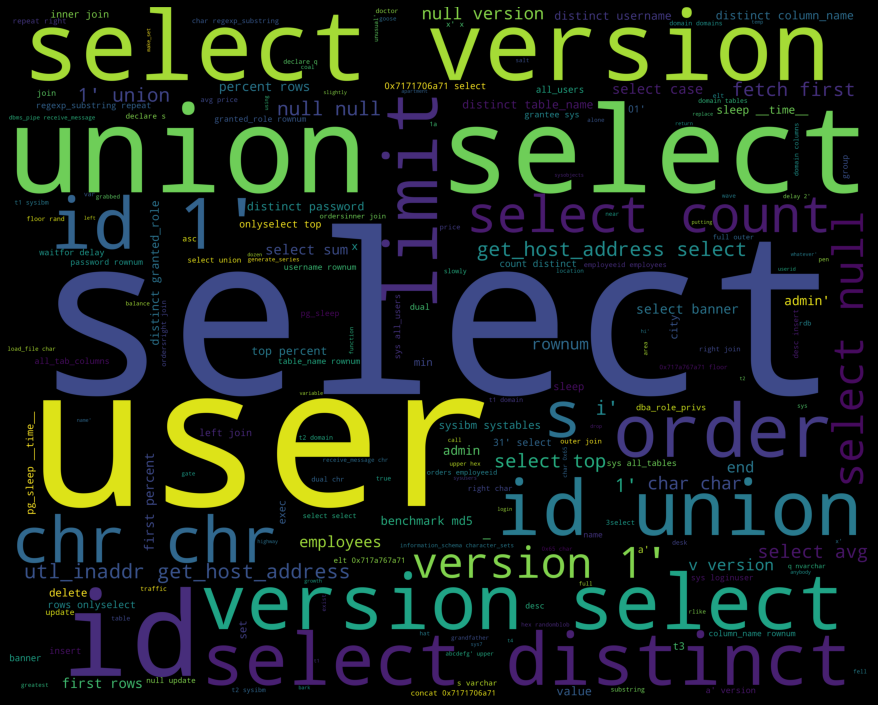

In [13]:
text = train.sqlstmt.values

Plot_world(text)

In [14]:
# further understand data: How many unique words in text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [15]:
counter = counter_word(train["sqlstmt"])

In [16]:
print(f"The number of unique words is: {len(counter)}")
list(counter.items())[:20]

The number of unique words is: 2729


[('"', 76),
 ('or', 691),
 ('pg_sleep', 21),
 ('(', 1447),
 ('__TIME__', 29),
 (')', 1547),
 ('--', 521),
 ('AND', 171),
 ('1', 1407),
 ('=', 1458),
 ('utl_inaddr.get_host_address', 52),
 ('SELECT', 768),
 ('DISTINCT', 103),
 ('table_name', 17),
 ('FROM', 738),
 (',', 49),
 ('ROWNUM', 41),
 ('AS', 106),
 ('LIMIT', 92),
 ('sys.all_tables', 9)]

In [17]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each sqlstmt.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_tok for words not in word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [18]:
# prepare training and test data
training_sentences = train.sqlstmt[0:training_size]
training_labels = train.label[0:training_size]

testing_sentences = test.sqlstmt[0:training_size]
testing_labels = test.label[0:training_size]

In [19]:
# about the training and test data
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (1610,)
The Shape of testing (4292,)


In [20]:
# tokenize sqlstmt
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [21]:
word_index = tokenizer.word_index

In [22]:
# show some training data
training_sentences.value_counts()[:10]

#NAME?                                                                                                                                                                                                               2
 select * from users where id  =  1 union select @<@$,version  (    )   -- 1                                                                                                                                         1
INSERT INTO usually ( living, everything, story, opinion, tape, scientific )  VALUES  ( 'chain', 'journey'. deer', 'frozen', 'shallow', 'shake', 'age' )                                                             1
SELECT * FROM whistle WHERE some = 'door'                                                                                                                                                                            1
 select * from users where id  =  1 or "%;" or 1  =  1 -- 1                                                                                 

In [23]:
# show tokenized sqlstmt
print(word_index)

{'<XXX>': 1, '1': 2, 'select': 3, 'from': 4, 'where': 5, 'or': 6, 'users': 7, 'id': 8, 'union': 9, 'version': 10, 'and': 11, 'as': 12, "'": 13, 'null': 14, "1'": 15, "'1'": 16, '3': 17, 'distinct': 18, 'limit': 19, 'chr': 20, 's': 21, 'all': 22, 'char': 23, 'count': 24, 'rownum': 25, 'by': 26, 'not': 27, '0': 28, 'order': 29, 'top': 30, 'join': 31, 'get': 32, 'name': 33, 'utl': 34, 'host': 35, 'inaddr': 36, 'address': 37, 'sleep': 38, 'between': 39, "'i'": 40, "'i": 41, '113': 42, 'like': 43, 'fetch': 44, 'first': 45, 'rows': 46, 'avg': 47, 'orders': 48, 'percent': 49, 'sys': 50, '50': 51, 'employees': 52, 'v': 53, 'time': 54, 'banner': 55, 'only': 56, '5': 57, 'in': 58, 'end': 59, 'on': 60, 'role': 61, 'case': 62, 'else': 63, 'sum': 64, 'when': 65, 'then': 66, "'1996": 67, '07': 68, 'column': 69, 'password': 70, 'pg': 71, 'table': 72, 'sysusers': 73, 'admin': 74, 'username': 75, "admin'": 76, '2': 77, 'a': 78, 'benchmark': 79, 'md5': 80, 'into': 81, '122': 82, 'insert': 83, 'granted':

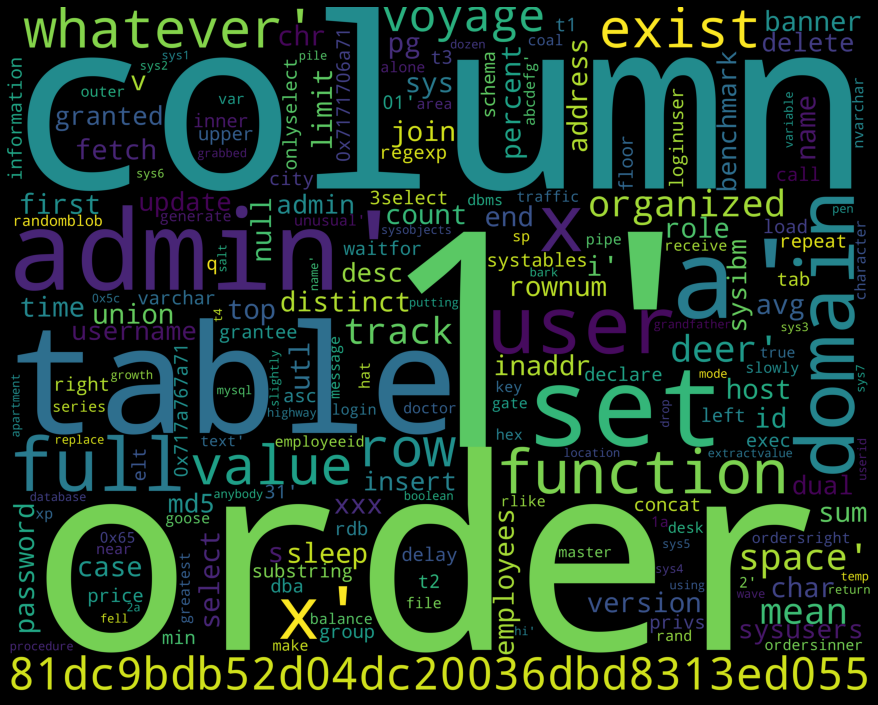

In [24]:
Plot_world(word_index)

In [25]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [27]:
# what the tokenized padded data looks like which will be used to build and test the model
print(training_padded[1])
print(training_labels[1])

[11  2 34 36 32 35 37  3 18 72 33  4  3 18 72 33 25 12 19  4]
1


In [28]:
print(testing_padded[1])
print(testing_labels[1])

[   2   11  112  503  503 1014   11    1    1    0    0    0    0    0
    0    0    0    0    0    0]
1


In [29]:
# show sqlstmt and tokenized sql stmt
print(train.sqlstmt[1])
print(training_sequences[1])
print(train.sqlstmt[1])
print(training_sequences[1])

 AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELECT DISTINCT  (  table_name  )  , ROWNUM AS LIMIT FROM sys.all_tables  )   WHERE LIMIT  =  5   )    )    AND 'i'  =  'i
[11, 2, 34, 36, 32, 35, 37, 3, 18, 72, 33, 4, 3, 18, 72, 33, 25, 12, 19, 4, 50, 22, 86, 5, 19, 57, 11, 40, 41]
 AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELECT DISTINCT  (  table_name  )  , ROWNUM AS LIMIT FROM sys.all_tables  )   WHERE LIMIT  =  5   )    )    AND 'i'  =  'i
[11, 2, 34, 36, 32, 35, 37, 3, 18, 72, 33, 4, 3, 18, 72, 33, 25, 12, 19, 4, 50, 22, 86, 5, 19, 57, 11, 40, 41]


In [30]:
# Classification
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary clasification
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            87328     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 138,813
Trainable params: 138,813
Non-trainable params: 0
_________________________________________________________________


In [32]:
# build model
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/10
51/51 [==============================] - 3s 22ms/step - loss: 0.4919 - accuracy: 0.7112 - val_loss: 0.1690 - val_accuracy: 0.9494
Epoch 2/10
51/51 [==============================] - 1s 11ms/step - loss: 0.0576 - accuracy: 0.9894 - val_loss: 0.1820 - val_accuracy: 0.9515
Epoch 3/10
51/51 [==============================] - 1s 11ms/step - loss: 0.0373 - accuracy: 0.9925 - val_loss: 0.0640 - val_accuracy: 0.9807
Epoch 4/10
51/51 [==============================] - 1s 11ms/step - loss: 0.0283 - accuracy: 0.9932 - val_loss: 0.0675 - val_accuracy: 0.9807
Epoch 5/10
51/51 [==============================] - 1s 11ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0949 - val_accuracy: 0.9772
Epoch 6/10
51/51 [==============================] - 1s 11ms/step - loss: 9.8177e-04 - accuracy: 1.0000 - val_loss: 0.1038 - val_accuracy: 0.9772
Epoch 7/10
51/51 [==============================] - 1s 11ms/step - loss: 5.8801e-04 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9772
Epoch

In [33]:
# about the model: accuracy, et..
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.000191,1.0,0.130105,0.976701
1,0.000157,1.0,0.133465,0.976701
2,0.000132,1.0,0.136469,0.976701
3,0.000113,1.0,0.139218,0.976701
4,0.000097,1.0,0.141628,0.976701


In [34]:
# Model accuracy: training and test
loss, accuracy = model.evaluate(training_padded, training_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
test_loss, test_accuracy = model.evaluate(testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9767


In [35]:
# model evaluation [inference] feed model new data

In [40]:
# add 3 sql statements in a csv file and predict whether sqli or not
# this file would contain the server access log data where only the server request string is extracted
# row 1, 2 is sqli, row 3 not

test2 = pd.read_csv("_sqli2_singlestmt.csv")

testing_sequences2 = tokenizer.texts_to_sequences(test2.sqlstmt)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(testing_padded2)
print(predictions.shape)
print(predictions)

print(test2) #print test data


(3, 1)
[[9.9996674e-01]
 [9.9995530e-01]
 [6.8112429e-05]]
                                             sqlstmt
0   select * from users where id  =  1 or 1#"  ( ...
1            1'+  (  select tafk where 9652  =  9652
2     SELECT * FROM balloon ORDER BY climate, mostly


In [41]:
# check if sql injection by passing sql statement
# When server access log data is streamed such routine can detect sqli and an automated response can be designed

def checkIfSQLi (sqlinput):
    testing_sequencesi = tokenizer.texts_to_sequences(sqlinput)
    testing_paddedi = pad_sequences(testing_sequencesi, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(testing_paddedi)
    return(predictions[0])

In [43]:
# use packaged model to check if log entry is sqli or not
print(checkIfSQLi('select * from users where id  =  1 or 1#'))

[0.99995446]


In [51]:
# Clustering with MiniBatchKMeans 
#   a variant of kmeans uses randomly sampled subsets of the input data to reduce compute time

In [52]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [53]:
#Feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(train.sqlstmt.values)
features = vec.transform(train.sqlstmt.values)

In [54]:
#print(features)

In [55]:
random_state = 0 
cls = MiniBatchKMeans(n_clusters=2, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=2, random_state=0)

In [56]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([0, 0, 1, ..., 0, 0, 0])

In [57]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

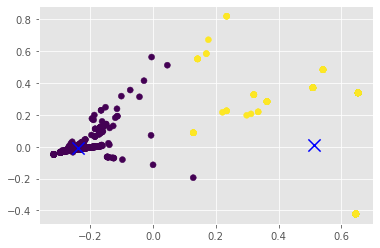

In [58]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [59]:
#evaluation
# perfect labeling are homogenous [1.0] less include samples from different classes
from sklearn.metrics import homogeneity_score
homogeneity_score(train.label, cls.predict(features))

0.23153087060824334